# Data description & Problem statement: 
This radar data was collected by a system in Goose Bay, Labrador. This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts. The targets were free electrons in the ionosphere. "Good" radar returns are those showing evidence of some type of structure in the ionosphere. "Bad" returns are those that do not; their signals pass through the ionosphere. 

Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number. There were 17 pulse numbers for the Goose Bay system. Instances in this databse are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal.

* Dataset is imbalanced. The data has 351 rows and 34 variables.
* This is a binary classification task. The classification goal is to predict whether the signals pass through the Ionosphere or not.


# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc.
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build an initial XGBoost model, and evaluate it via C-V approach
- Use grid-search along with C-V approach to find the best hyperparameters of XGBoost model: Find the best XGBoost model (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the best XGBoost model with optimized hyperparameters on Test Dataset, by calculating:
     - AUC score
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision
     
Finally, calculate the Feature Importance. 

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [18]:
df=pd.read_csv('Ionosphere.csv', sep=',')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V26,V27,V28,V29,V30,V31,V32,V33,V34,Class
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1


In [3]:
X=df.drop(['Class'], axis=1)
y=df['Class']

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
# PCA: _________________
from sklearn.decomposition import PCA 

pca=PCA(n_components=10, whiten=True, random_state=42)
pca.fit(X_train)
X_trainPCA=pca.transform(X_train)
X_testPCA=pca.transform(X_test)

In [5]:
sum(pca.explained_variance_ratio_)

0.7718483748650915

In [6]:
X_trainWithPCA=np.hstack((X_train.as_matrix(), X_trainPCA))
X_testWithPCA=np.hstack((X_test.as_matrix(), X_testPCA))

In [8]:
#Imbalanced Dataset:
y.value_counts()

1    225
0    126
Name: Class, dtype: int64

In [9]:
# Building the Initial Model & Cross-Validation: 
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

model=XGBClassifier(scale_pos_weight=225/126) 
kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(model, X_trainWithPCA, y_train, cv=kfold, scoring='roc_auc')

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.96594427 0.97832817 0.94582043 0.95665635 1.        ] 

Accuracy: 0.97 (+/- 0.02)


In [10]:
# Grid-Search for the best model parameters: 

# Resampling:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

X_r, y_r=X_trainWithPCA, y_train
#X_r, y_r = SMOTE(random_state=42).fit_sample(X_train, y_train)
#X_r, y_r = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)

# We create a sample_weight list for this imbalanced dataset:
from sklearn.utils.class_weight import compute_sample_weight
sw=compute_sample_weight(class_weight='balanced', y=y_r)


from sklearn.model_selection import GridSearchCV
param={'max_depth':[2, 4, 6], 'min_child_weight':[1, 2, 10], 'gamma': [ 0, 0.05, 0.1], 'subsample':[0.7, 1]}

kfold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search=GridSearchCV(XGBClassifier(seed=42), param, cv=kfold, n_jobs=-1, scoring="roc_auc")
grid_search.fit(X_r, y_r, sample_weight=sw)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
18,0.045878,0.000814,0.000997,2.973602e-07,0.05,2,1,0.7,"{'gamma': 0.05, 'max_depth': 2, 'min_child_wei...",0.975329,0.940668,0.984447,0.966879,0.018802,1,1.0,1.0,1.0,1.0,0.0
49,0.075132,0.008707,0.001995,4.495664e-07,0.1,6,1,1,"{'gamma': 0.1, 'max_depth': 6, 'min_child_weig...",0.973684,0.942396,0.982143,0.966132,0.017043,2,1.0,1.0,1.0,1.0,0.0
31,0.076794,0.009600,0.001995,2.247832e-07,0.05,6,1,1,"{'gamma': 0.05, 'max_depth': 6, 'min_child_wei...",0.976425,0.938364,0.982719,0.965917,0.019542,3,1.0,1.0,1.0,1.0,0.0


In [11]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_testWithPCA, np.array(y_test)),2))

Best parameters:  {'gamma': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.7}
Best validation accuracy:  0.97 (+/- 0.02)
Test score:  0.99


Confusion matrix, without normalization
[[28  4]
 [ 1 55]]
Normalized confusion matrix
[[0.88 0.12]
 [0.02 0.98]]


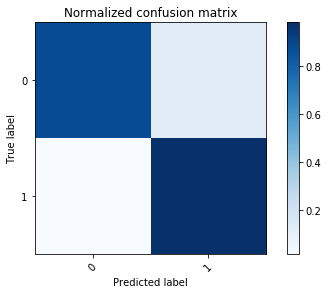

In [12]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

names = ["0", "1"]

# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_testWithPCA))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, names, title='Normalized confusion matrix')

plt.show()

In [13]:
# Classification report:
report=classification_report(y_test, grid_search.predict(X_testWithPCA))
print(report)

             precision    recall  f1-score   support

          0       0.97      0.88      0.92        32
          1       0.93      0.98      0.96        56

avg / total       0.94      0.94      0.94        88



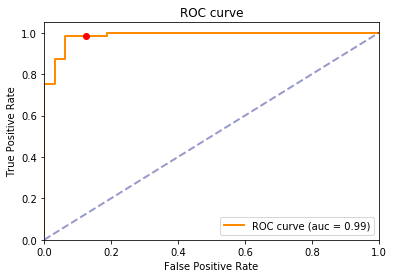

In [14]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid_search.predict_proba(X_testWithPCA)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.predict_proba(X_testWithPCA)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

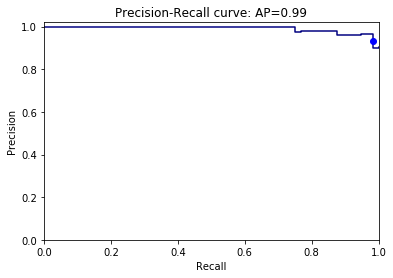

In [15]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test,grid_search.predict_proba(X_testWithPCA)[:, 1],  pos_label=1)
ave_precision=average_precision_score(y_test,grid_search.predict_proba(X_testWithPCA)[:, 1])

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot([cm_normalized[1,1]], [cm[1,1]/(cm[1,1]+cm[0,1])], 'ob')
plt.show()

('V5', 0.11111111)
('V3', 0.06666667)
('V8', 0.05925926)
('V6', 0.055555556)
('V24', 0.055555556)
('V27', 0.055555556)
('V28', 0.055555556)
('V22', 0.05185185)
('V4', 0.048148148)
('V14', 0.04074074)
('V18', 0.033333335)
('V21', 0.033333335)
('V30', 0.033333335)
('V9', 0.02962963)
('V26', 0.02962963)
('V7', 0.025925925)
('V17', 0.025925925)
('V10', 0.022222223)
('V16', 0.022222223)
('V34', 0.022222223)
('V31', 0.018518519)
('V33', 0.018518519)
('V25', 0.014814815)
('V11', 0.011111111)
('V20', 0.011111111)
('V29', 0.011111111)
('V32', 0.011111111)
('V12', 0.0074074073)
('V15', 0.0074074073)
('V23', 0.0074074073)
('V13', 0.0037037036)
('V1', 0.0)
('V2', 0.0)
('V19', 0.0)


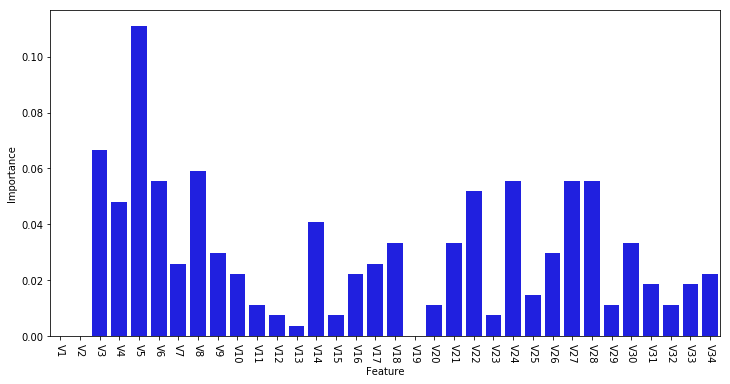

In [16]:
# Feature Importance:
im=XGBClassifier(**grid_search.best_params_).fit(X,y).feature_importances_

# Sort & Plot:
d=dict(zip(np.array(X.columns), im))
k=sorted(d,key=lambda i: d[i], reverse= True)
[print((i,d[i])) for i in k]

# Plot:
c1=pd.DataFrame(np.array(im),  columns=["Importance"])
c2=pd.DataFrame(np.array(X.columns[0:]),columns=["Feature"])

fig, ax = plt.subplots(figsize=(12,6)) 
sns.barplot(x="Feature", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)
plt.xticks(rotation=-90)

plt.show()